Activate the project

In [1]:
using Pkg
Pkg.activate("..")

  Activating environment at `~/Documents/repos/kp-lflm-group/Project.toml`


# Load the package KPpack

In [2]:
using KPpack

┌ Info: Precompiling KPpack [26ea0ef3-e7b0-494e-b39b-84c42b7463c6]
└ @ Base loading.jl:1342


# Create a KP model

In [3]:
using Symbolics, LinearAlgebra
using PyCall, PyPlot

In [4]:
#read Hamiltonian created in createHam.ipynb 
dirHam="/home/martinez/Documents/repos/kp-lflm-group/Models_Hamiltonian/";name="kane"

Htot=KPpack.readHamiltonian(dirHam,name)

strK=["k_x","k_y","k_z"];
Emomentum=KPpack.setMomentum(strK);
HVar=KPpack.getVar(Htot)

14-element Vector{Num}:
    E_g
 VBO
   c
    F
 k_x
 k_y
 k_z
 g_1
 g_2
    E_p
 g_3
   Δ
   P
  cp

In [5]:
real(Htot)

8×8 Matrix{Num}:
  E_g + VBO + c*(1 + 2F)*(k_x^2 + k_y^2 + k_z^2)  …                         0
 0                                                                          0.333333Δ
 0                                                                          0
 0                                                                          0
 0                                                                          0
 0                                                …     -c*k_x*k_z*(6g_3 + (-E_p) / E_g)
 0                                                      -c*k_y*k_z*(6g_3 + (-E_p) / E_g)
 0                                                   VBO - c*(g_1 + 4g_2 + (-E_p) / E_g)*(k_z^2) - c*(g_1 - 2g_2)*(k_x^2 + k_y^2)

In [6]:
var=Emomentum[3] 
H0,H1,H2=KPpack.createKm(Htot,var);
#p=HVar[13];
#p=HVar[14]; b = HVar[8];
p=HVar[13]; b = HVar[1];
kind="nonSymm"
H1l,H1r=KPpack.createH1Corr(H1,p,b,Emomentum,kind);

In [7]:
imag(H1l)

8×8 Matrix{Num}:
 0  …                  0
 0                     0
 0                     0
 0                     0
 0                     0
 0  …        (-c*k_x*s*(E_p - 6E_g*g_3)) / E_g
 0     (c*k_y*(1 - s)*(6E_g*g_3 - E_p)) / E_g
 0                     0

## test the bulk calculation

In [8]:
material="GaAs"; Temp=30; soc=true; opt="one"
#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

mm=KPpack.Materials(material,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0);
KPpack.ParMat(mm,Temp,opt);
#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

In [9]:
mm.Eg+mm.VBO

0.7169192307692307

In [10]:
kmax= 1.4; Nt=20; consth=0.038; const2=sqrt(consth)
Ktot,Etot=KPpack.calcBandBulk(mm,kmax,Nt,Htot,Emomentum,consth,const2)
#++++++++++++++++++++++++

EDOS, aDOS = KPpack.DOS(-2,2.2,0.01,Etot,0.04);

In [11]:
mm.Eg+mm.VBO

0.7169192307692307

# Plot band diagram

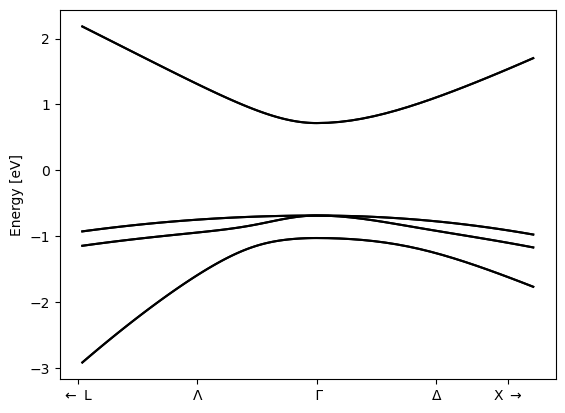

In [12]:
KPpack.PlotBands(Etot,Ktot);

# Plot DOS

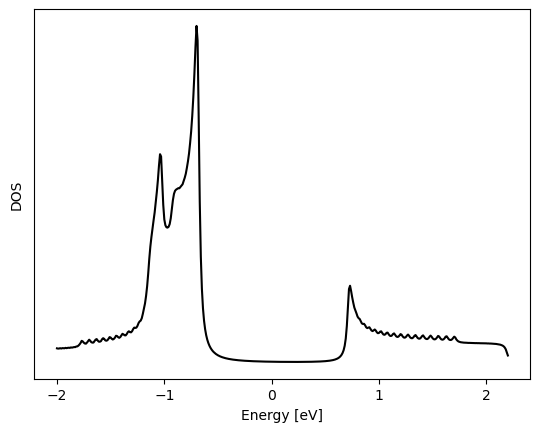

In [13]:
KPpack.PlotDOS(EDOS,aDOS);

# Make a structure

In [14]:

#structure=[
#    "InAlAs_0.52" "10";
#    "InGaAs_0.53" "8";
#    "InAlAs_0.52" "10";]

structure=["AlGaAs_0.2" "10";
    "GaAs" "5";
    "AlGaAs_0.2" "1";
    "GaAs" "5";
    "AlGaAs_0.2" "10";]

#structure=["AlGaAs_0.3" "10";
#    "GaAs" "15";
#    "AlGaAs_0.3" "10";]


Npts,layer,nlayer=KPpack.setStructure(structure,1.3,Temp)

X,boundary =KPpack.mesh(Npts,layer,nlayer);
mlayer=Array{KPpack.Materials}(undef, length(X));

boundPoints=KPpack.supParams(layer,X,boundary,mlayer,Temp,opt);
Npts

143

# Plot structure

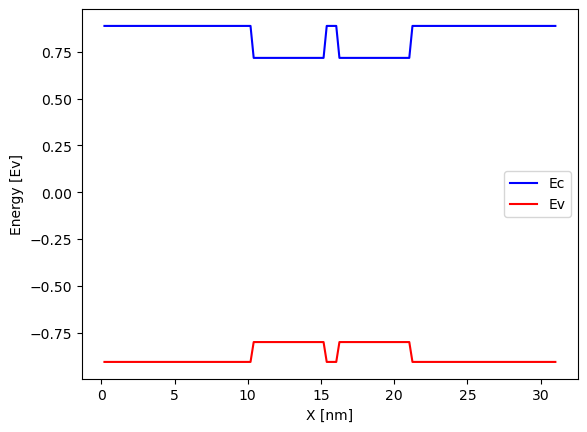

In [15]:
kind="both"
KPpack.plotProf(mlayer,X,kind);

## find eigenvalues solving for K=0

In [16]:
c=0.038; cps=sqrt(c); dx=X[2]-X[1];  cr=0.9; s=0.5; pb=true; siz=size(H0)[1]
kmax= 0.6; Nt=100;

nc=6; nv=6
@time KqwBand, EcqwBand, EvqwBand, sV,sC,pos, Eqw0, EVqw0 = KPpack.resolveQWbands(mlayer,kmax,Nt,dx,Npts,H0,H1l,H1r,H2,nc,nv,c,cps,siz,Emomentum,pb,cr,s);

 36.699046 seconds (35.80 M allocations: 10.085 GiB, 5.55% gc time)


# QW Band Structure Calculation

## Valence Band 

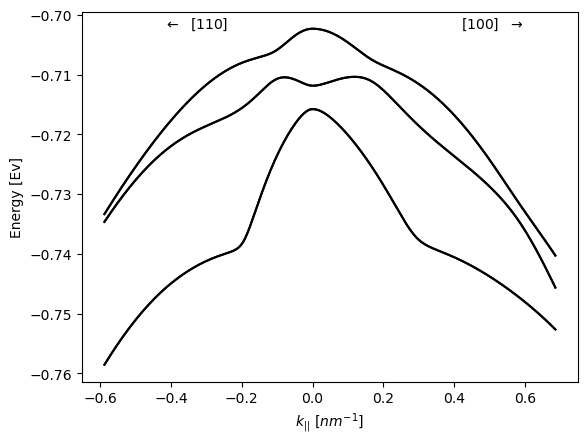

In [17]:
option="complete_V"; poslab=sV
KPpack.PlotQWBand(EvqwBand,EcqwBand,KqwBand,option,poslab,kmax);

## Conduction Band

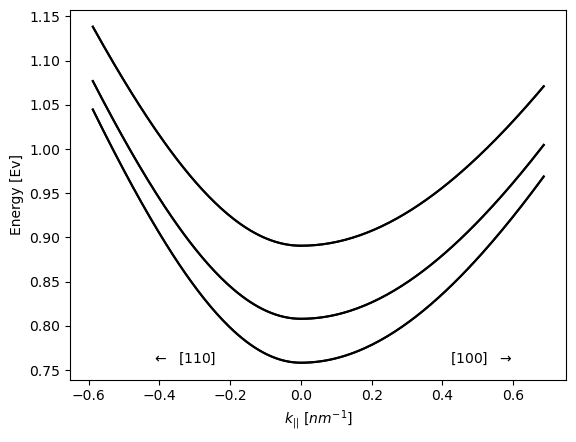

In [18]:
option="complete_C"; poslab=sC
KPpack.PlotQWBand(EvqwBand,EcqwBand,KqwBand,option,poslab,kmax);

# DOS QW

## DOS Valence Band

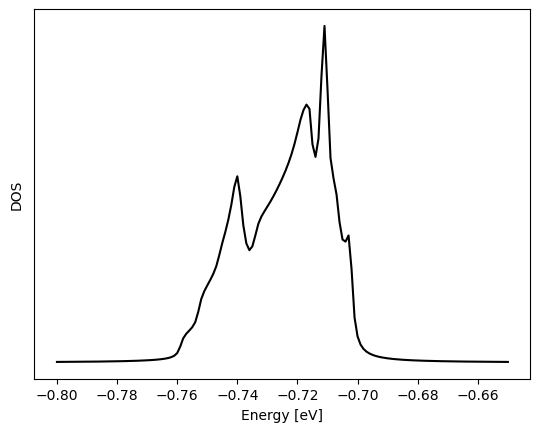

In [19]:
EDOSv, aDOSv = KPpack.DOS(-0.8,-0.65,0.001,EvqwBand,2e-3);
KPpack.PlotDOS(EDOSv,aDOSv);

## DOS Conduction Band

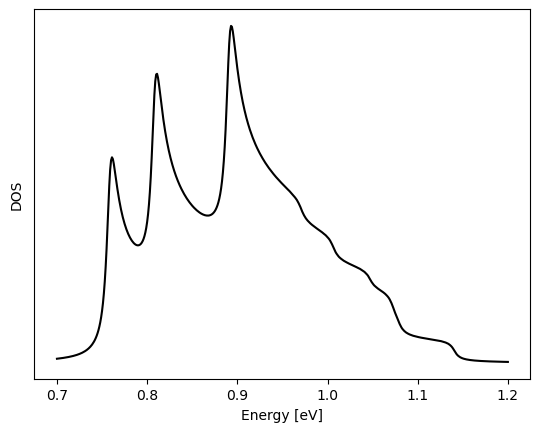

In [20]:
EDOSc, aDOSc = KPpack.DOS(0.7,1.2,0.001,EcqwBand,1e-2);
KPpack.PlotDOS(EDOSc,aDOSc);

## =====================================================|

# Envelope functions magnitude

# ================================

## Components of First Conduction band (CB)

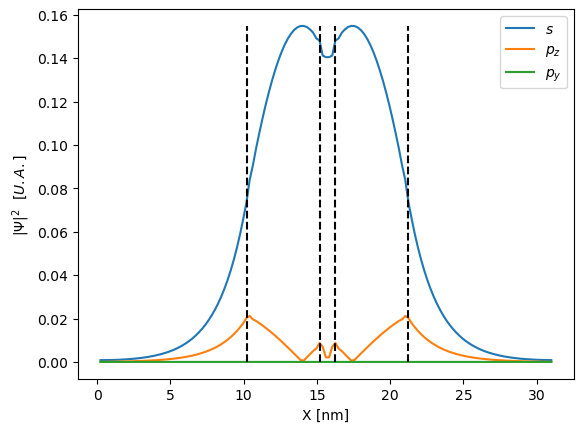

0.7582794879710886

In [21]:
iVec=1;vecband=[1,4,3]; legendArr=[L"s",L"p_z",L"p_y"]

KPpack.plotProbDistr(iVec,pos,EVqw0,siz,vecband,boundary,X,legendArr)
Eqw0[pos+1]

## Components of Second Conduction band (CB)

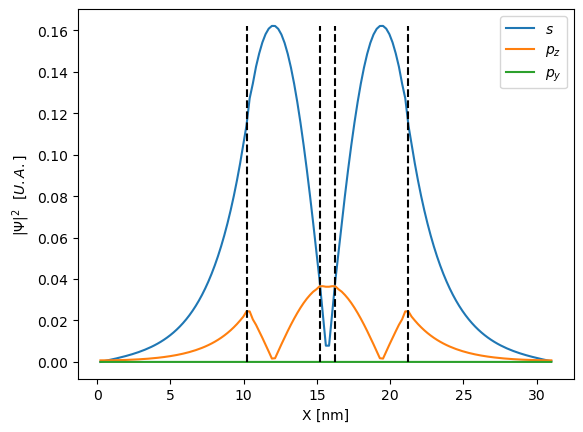

0.8079793664865107

In [22]:
iVec=4;vecband=[5,8,7]; legendArr=[L"s",L"p_z",L"p_y"]

KPpack.plotProbDistr(iVec,pos,EVqw0,siz,vecband,boundary,X,legendArr)
Eqw0[pos+iVec]

## Components of First Light Hole band (HL)

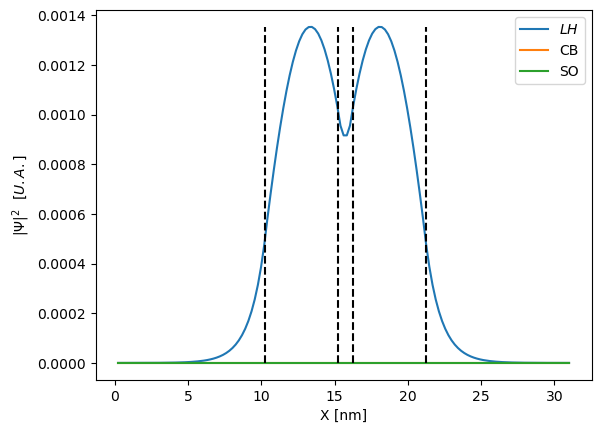

In [23]:
iVec=-1;vecband=[2,1,4]; legendArr=[L"LH","CB","SO"]

KPpack.plotProbDistr(iVec,pos,EVqw0,siz,vecband,boundary,X,legendArr)

# ======================================================

# Surfaces of valence band quantum Well

In [24]:
kinic,kend=-1.0,1.0; kstep=0.1
@time EArrv=KPpack.eigenSurface(H0,H1r,H1l,H2,mlayer,dx,c,cps,Npts,Emomentum,pb,cr,s,sV,nv,kinic,kend,kstep);

 40.810227 seconds (37.82 M allocations: 16.601 GiB, 4.92% gc time, 0.50% compilation time)


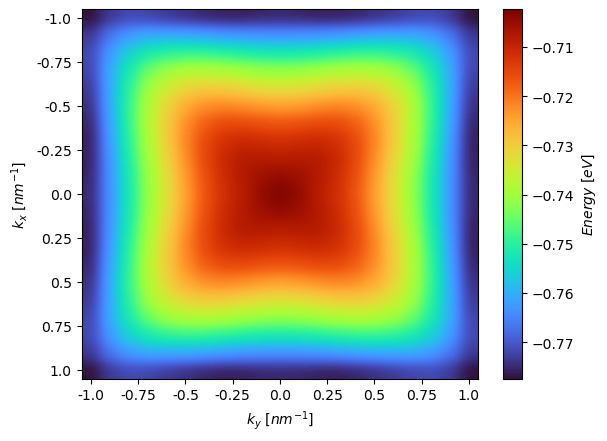

In [25]:
KPpack.plotEigSurface(EArrv,1,kinic,kend)

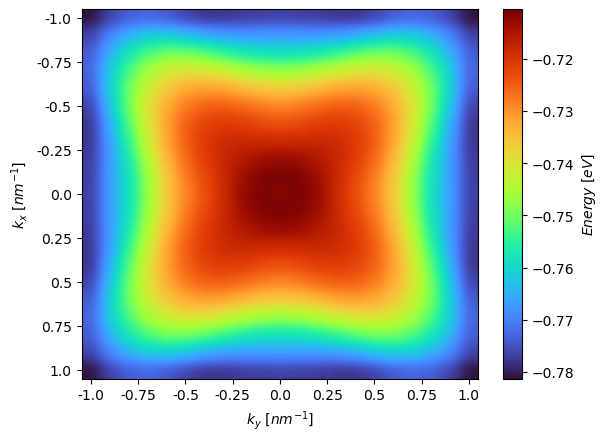

In [26]:
KPpack.plotEigSurface(EArrv,3,kinic,kend)

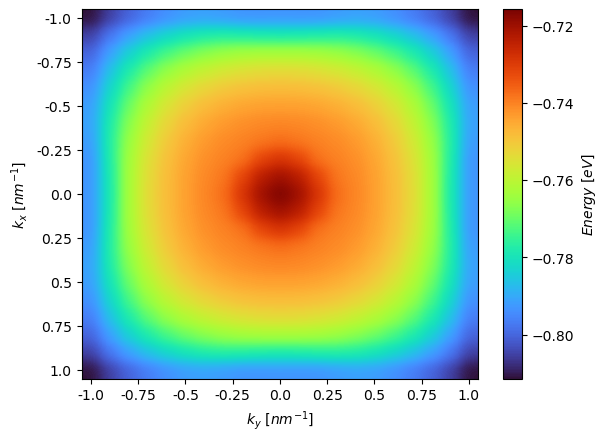

In [27]:
KPpack.plotEigSurface(EArrv,5,kinic,kend)

# Surfaces of conduction band quantum Well

In [28]:
kinic,kend=-1.0,1.0; kstep=0.1
@time EArr=KPpack.eigenSurface(H0,H1r,H1l,H2,mlayer,dx,c,cps,Npts,Emomentum,pb,cr,s,sC,nc,kinic,kend,kstep);

 53.471431 seconds (38.02 M allocations: 18.240 GiB, 3.78% gc time)


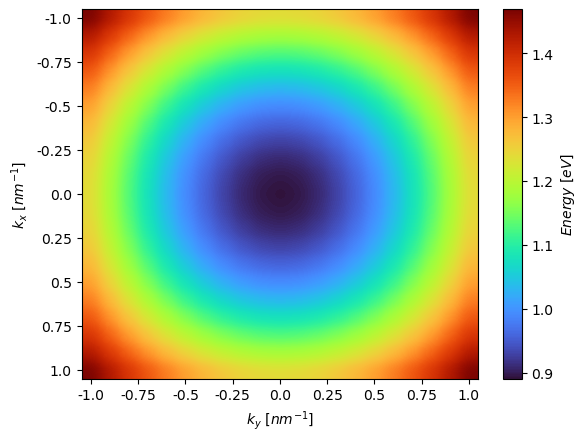

In [29]:
KPpack.plotEigSurface(EArr,1,kinic,kend)

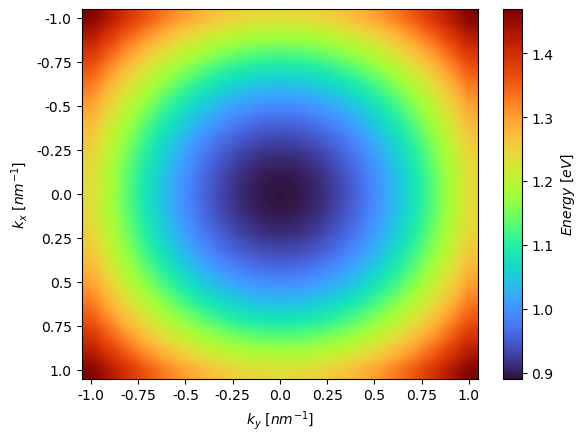

In [30]:
KPpack.plotEigSurface(EArr,2,kinic,kend)